This is the first of a series of posts discussing a side project I'm working on. Long term, I'm interested in solving the PDEs I'm studying in my research using deep neural networks. This is a natural approach, but having not implemented such a program before, I'm starting with some easier problems to get myself familiar with the implementation of such a solver using Pytorch. Most of my experience up until recently has been with Tensorflow (I have a Tensorflow Developer certification from Coursera). So far, I've enjoyed Pytorch and I've found it much more intuitive than Tensorflow. 

## Poisson Equation
The first toy problem I present here is the Poisson Equation with Dirichlet boundary condition on the unit disk. I've chosen a very simple relationship for $\Delta u$ and the boundary condition to quickly show that the neural network I train differs only slightly from the analytical solution.

The problem I solve is this,

$$\Delta u(x,y)=1\quad (x,y)\in B_1(0)$$
$$u(x,y)=0\quad (x,y)\in\partial B_1(0)$$

in $\mathbb{R}^2$. The analytical solution to this problem is easily seen to be $u(x,y)=\frac{1}{4}(x^2+y^2-1)$. 

In [322]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import math

We will use a very simple neural network.

In [241]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Linear(2, 8),
            nn.Sigmoid(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.sequential_model(x)

Here, we define a function which samples the necessary data to train the network (and test the network later).

In [235]:
def SampleFromUnitDisk(points):
    d = torch.distributions.Uniform(-1,1)

    x = torch.Tensor(points,1)
    y = torch.Tensor(points,1)
    j=0

    while j<points:
        x_temp = d.sample()
        y_temp = d.sample()
        if x_temp**2+y_temp**2<1:
            x[j,0]=x_temp
            y[j,0]=y_temp
            j+=1

    xbdry = torch.Tensor(points,1)
    ybdry = torch.Tensor(points,1)
    j=0

    #Vary the sign of the y coordinate, for otherwise we'd only have positive y values.

    for j in range(points):
        x_temp = d.sample()
        xbdry[j,0]=x_temp
        if j%2==0:
            ybdry[j,0]=math.sqrt(1-x_temp**2)
        else:
            ybdry[j,0]=-math.sqrt(1-x_temp**2)

    return x, y, xbdry, ybdry

Now, we generate the training data.

In [236]:
x, y, xbdry, ybdry = SampleFromUnitDisk(10000)

Let's discuss the loss function. Since we've descritized the domain, we are going to use a discrete mean-squared error function to compute the loss. In our case, we want to minimize the following,

$$L(x_{\text{int}},y_\text{int}, x_{\text{bdry}},y_{\text{bdry}}):=\frac{1}{N_{\text{int}}}\sum_{j=1}^{N_{\text{int}}}|\Delta u(x^{(j)}_{\text{int}},y^{(j)}_{\text{int}})-1|^2+\frac{1}{N_{\text{bdry}}}\sum_{j=1}^{N_{\text{bdry}}}|u(x^{(j)}_{\text{bdry}},y^{(j)}_{\text{bdry}})|^2$$

The first term comes from the fact that $\Delta u(x,y)=1$ on the interior, while $u=0$ identically on the boundary. To implement this, we define the following.

In [237]:
def loss(x, y, xbdry, ybdry, network):
    x.requires_grad = True
    y.requires_grad = True
    temp_input = torch.cat((x,y),1)
    z=network(temp_input)
    zbdry = network(torch.cat((xbdry, ybdry),1))

    dz_dx = torch.autograd.grad(z.sum(), x, create_graph = True)[0]
    ddz_ddx = torch.autograd.grad(dz_dx.sum(), x, create_graph = True)[0]
    dz_dy = torch.autograd.grad(z.sum(), y, create_graph = True)[0] 
    ddz_ddy = torch.autograd.grad(dz_dy.sum(), y, create_graph = True)[0]

    return torch.mean((ddz_ddx+ddz_ddy-1)**2)+torch.mean((zbdry-torch.zeros(xbdry.size(0)))**2)

Okay now let's create our network and train it! We'll use 2000 epochs.

In [245]:
model = NeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)

epochs = 2000
loss_values = np.zeros(2000)
for i in range(epochs):
    l = loss(x, y, xbdry, ybdry, model)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_values[i]=l
    if i%100==0:
        print("Loss at epoch {}: {}".format(i, l.item()))

Loss at epoch 0: 1.0297363996505737
Loss at epoch 100: 0.7696019411087036
Loss at epoch 200: 0.10838701575994492
Loss at epoch 300: 0.040865253657102585
Loss at epoch 400: 0.02691115066409111
Loss at epoch 500: 0.02078372612595558
Loss at epoch 600: 0.017054535448551178
Loss at epoch 700: 0.0143966656178236
Loss at epoch 800: 0.012377198785543442
Loss at epoch 900: 0.010792599990963936
Loss at epoch 1000: 0.00952119193971157
Loss at epoch 1100: 0.008482505567371845
Loss at epoch 1200: 0.007620864547789097
Loss at epoch 1300: 0.006896625738590956
Loss at epoch 1400: 0.006280942354351282
Loss at epoch 1500: 0.005752396769821644
Loss at epoch 1600: 0.005294801667332649
Loss at epoch 1700: 0.004895701073110104
Loss at epoch 1800: 0.00454533938318491
Loss at epoch 1900: 0.004236005246639252


Cool, so it seems like we've decreased the loss significantly. This is enough for our toy example. Here's the loss decrease over the course of training:

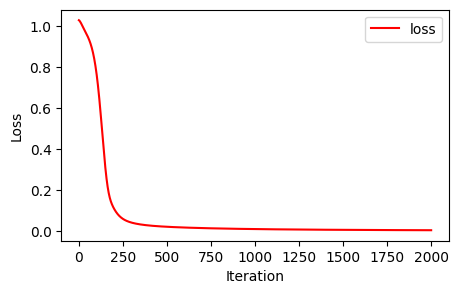

In [246]:
x_axis = np.linspace(0,2000,2000)[:,None]
plt.figure(figsize=(5,3))
plt.plot(x_axis,loss_values,'red', label='loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

Now, let's simulate a sup-norm test agains the analytic solution, using a test set of data.

In [250]:
x_test, y_test, xbdry_test, ybdry_test = SampleFromUnitDisk(10000)

with torch.no_grad():
    z = model(torch.cat((x_test,y_test),1))-(1/4*(x_test**2+y_test**2-1))
    print("Interior sup-norm error: {}".format(torch.max(abs(z)).item()))

with torch.no_grad():
    z = model(torch.cat((xbdry_test,ybdry_test),1))-(1/4*(xbdry_test**2+ybdry_test**2-1))
    print("Boundary sup-norm error: {}".format(torch.max(abs(z)).item()))

Interior sup-norm error: 0.04881325364112854
Boundary sup-norm error: 0.04888451099395752


Of course, we want to do better, but this is pretty decent for this toy example.

Cool, so we have a baseline implementation for solving PDEs using neural networks. This was of course extremely simple. I started messing with more complicated PDEs (quasilinear, nonlinear) and ran into challenges in both implementation and validation. There are some theoretical questions on how to deal with non-uniqueness of solutions and how to give an "ansatz" when initializaing training. Some of this will probably be the subject of my next post. 